Blank


In [113]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import plot_model

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay

In [115]:
df = pd.read_csv('../../Data/complete_fire.csv')

In [116]:
df.dropna(inplace = True)

In [117]:
df.shape

(167273, 23)

In [118]:
df.dtypes

unique_fire_identifier     object
lattitude                 float64
longitude                 float64
acres_burned              float64
fire_cause                 object
incident_name              object
IsFSAssisted              float64
origin_county              object
state                      object
year                        int64
month                       int64
value                     float64
anomaly                   float64
area (acres)              float64
population                float64
d0                        float64
d1                        float64
d2                        float64
d3                        float64
d4                        float64
DSCI_avg                  float64
DSCI_summed               float64
precipitation(in)         float64
dtype: object

In [119]:
conditions = [df['acres_burned'] <= .25,
             (df['acres_burned'] > .25) & (df['acres_burned'] <= 9.9),
             (df['acres_burned'] > 9.9) & (df['acres_burned'] <= 99.99),
             (df['acres_burned'] > 99.99) & (df['acres_burned'] <= 299),
             (df['acres_burned'] > 299) & (df['acres_burned'] <= 999),
             (df['acres_burned'] > 999) & (df['acres_burned'] <= 5000),
             (df['acres_burned'] > 5000) & (df['acres_burned'] <= 9999),
             (df['acres_burned'] > 9999) & (df['acres_burned'] <= 49_999),
             (df['acres_burned'] > 49_999) & (df['acres_burned'] <= 100_000),
              (df['acres_burned'] > 100_000)
                
             ]
# choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
choices = [0,1,2,3,4,5,6,7,8,9]

df['class'] = np.select(conditions, choices, default = 'A')

In [120]:
df.dtypes

unique_fire_identifier     object
lattitude                 float64
longitude                 float64
acres_burned              float64
fire_cause                 object
incident_name              object
IsFSAssisted              float64
origin_county              object
state                      object
year                        int64
month                       int64
value                     float64
anomaly                   float64
area (acres)              float64
population                float64
d0                        float64
d1                        float64
d2                        float64
d3                        float64
d4                        float64
DSCI_avg                  float64
DSCI_summed               float64
precipitation(in)         float64
class                      object
dtype: object

In [121]:
df['class'].value_counts(normalize = True)

0    0.330621
1    0.230288
2    0.137398
5    0.112289
4    0.102718
3    0.080085
7    0.002983
6    0.002577
8    0.000544
9    0.000496
Name: class, dtype: float64

In [122]:

df = pd.get_dummies(df, columns = ['state', 'origin_county', 'fire_cause'], drop_first = True)

In [123]:
X = df.drop(columns = ['incident_name', 'unique_fire_identifier', 'class'])
y = df['class']

In [124]:
y = to_categorical(y)
# y = pd.get_dummies(y)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, stratify = y)

In [126]:
sc = StandardScaler()

In [127]:
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [128]:
X_train.shape

(125454, 1400)

In [129]:

model = Sequential()
model.add(Dense(32,
                input_shape = (1400,),
                activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [130]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [131]:

history = model.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
3921/3921 [==============================] - 9s 2ms/step - loss: 1.2856 - acc: 0.5372 - val_loss: 1.0906 - val_acc: 0.5893
Epoch 2/10
3921/3921 [==============================] - 8s 2ms/step - loss: 1.0056 - acc: 0.6136 - val_loss: 0.9816 - val_acc: 0.6248
Epoch 3/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.9003 - acc: 0.6448 - val_loss: 0.9264 - val_acc: 0.6490
Epoch 4/10
3921/3921 [==============================] - 7s 2ms/step - loss: 0.8387 - acc: 0.6672 - val_loss: 0.8920 - val_acc: 0.6613
Epoch 5/10
3921/3921 [==============================] - 6s 1ms/step - loss: 0.7997 - acc: 0.6801 - val_loss: 0.8645 - val_acc: 0.6729
Epoch 6/10
3921/3921 [==============================] - 6s 1ms/step - loss: 0.7680 - acc: 0.6886 - val_loss: 0.8555 - val_acc: 0.6836
Epoch 7/10
3921/3921 [==============================] - 6s 2ms/step - loss: 0.7468 - acc: 0.6963 - val_loss: 0.8660 - val_acc: 0.6814
Epoch 8/10
3921/3921 [==============================] - 6s 2ms

In [132]:
preds = model.predict(Z_test)

In [133]:
rounded_preds = np.argmax(preds, axis = -1)
rounded_preds[101]

2

In [134]:
y_test2 = np.argmax(y_test, axis = -1)

In [135]:
y_test2[101]

2

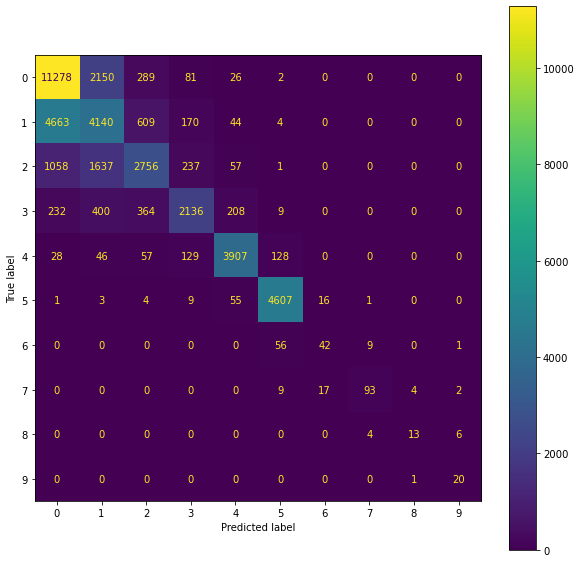

In [137]:

cm = confusion_matrix(y_test2, rounded_preds)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);


In [138]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
model2 = Sequential()
model2.add(Dense(64,
                input_shape = (1400,),
                activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(32, activation = 'relu'))

model2.add(Dense(10, activation = 'softmax'))

In [139]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [140]:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

history = model2.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
3921/3921 [==============================] - 9s 2ms/step - loss: 1.1550 - acc: 0.5511 - val_loss: 0.9756 - val_acc: 0.6114
Epoch 2/10
3921/3921 [==============================] - 9s 2ms/step - loss: 0.9559 - acc: 0.6208 - val_loss: 0.8842 - val_acc: 0.6416
Epoch 3/10
3921/3921 [==============================] - 8s 2ms/step - loss: 0.8838 - acc: 0.6421 - val_loss: 0.8350 - val_acc: 0.6581
Epoch 4/10
3921/3921 [==============================] - 8s 2ms/step - loss: 0.8382 - acc: 0.6567 - val_loss: 0.8199 - val_acc: 0.6594
Epoch 5/10
3921/3921 [==============================] - 10s 2ms/step - loss: 0.8073 - acc: 0.6667 - val_loss: 0.7890 - val_acc: 0.6703
Epoch 6/10
3921/3921 [==============================] - 10s 3ms/step - loss: 0.7819 - acc: 0.6738 - val_loss: 0.7644 - val_acc: 0.6803
Epoch 7/10
3921/3921 [==============================] - 8s 2ms/step - loss: 0.7581 - acc: 0.6811 - val_loss: 0.7466 - val_acc: 0.6867
Epoch 8/10
3921/3921 [==============================] - 8s 2

In [141]:
model3 = Sequential()
model3.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))

model3.add(Dense(10, activation = 'softmax'))

model3.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [142]:
history = model3.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 30,
                    batch_size = 64,
                    verbose = 1)

Epoch 1/30
1961/1961 [==============================] - 4s 2ms/step - loss: 1.2081 - acc: 0.5280 - val_loss: 1.0016 - val_acc: 0.6048
Epoch 2/30
1961/1961 [==============================] - 4s 2ms/step - loss: 0.9903 - acc: 0.6093 - val_loss: 0.9178 - val_acc: 0.6345
Epoch 3/30
1961/1961 [==============================] - 5s 3ms/step - loss: 0.9172 - acc: 0.6321 - val_loss: 0.8630 - val_acc: 0.6480
Epoch 4/30
1961/1961 [==============================] - 13s 7ms/step - loss: 0.8707 - acc: 0.6478 - val_loss: 0.8276 - val_acc: 0.6595
Epoch 5/30
1961/1961 [==============================] - 7s 4ms/step - loss: 0.8355 - acc: 0.6570 - val_loss: 0.8062 - val_acc: 0.6684
Epoch 6/30
1961/1961 [==============================] - 7s 3ms/step - loss: 0.8090 - acc: 0.6669 - val_loss: 0.7864 - val_acc: 0.6764
Epoch 7/30
1961/1961 [==============================] - 7s 3ms/step - loss: 0.7862 - acc: 0.6730 - val_loss: 0.7680 - val_acc: 0.6805
Epoch 8/30
1961/1961 [==============================] - 6s 3m

In [143]:
model4 = Sequential()
model4.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(32, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))

model4.add(Dense(10, activation = 'softmax'))

model4.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [144]:
history = model4.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,
                    verbose = 1)

Epoch 1/100
981/981 [==============================] - 3s 3ms/step - loss: 1.2587 - acc: 0.5102 - val_loss: 1.0496 - val_acc: 0.5841
Epoch 2/100
981/981 [==============================] - 2s 2ms/step - loss: 1.0361 - acc: 0.5932 - val_loss: 0.9731 - val_acc: 0.6177
Epoch 3/100
981/981 [==============================] - 2s 3ms/step - loss: 0.9575 - acc: 0.6213 - val_loss: 0.9053 - val_acc: 0.6386
Epoch 4/100
981/981 [==============================] - 5s 5ms/step - loss: 0.9042 - acc: 0.6354 - val_loss: 0.8620 - val_acc: 0.6531
Epoch 5/100
981/981 [==============================] - 5s 6ms/step - loss: 0.8673 - acc: 0.6483 - val_loss: 0.8382 - val_acc: 0.6585
Epoch 6/100
981/981 [==============================] - 4s 5ms/step - loss: 0.8392 - acc: 0.6569 - val_loss: 0.8132 - val_acc: 0.6668
Epoch 7/100
981/981 [==============================] - 4s 4ms/step - loss: 0.8143 - acc: 0.6651 - val_loss: 0.7959 - val_acc: 0.6740
Epoch 8/100
981/981 [==============================] - 5s 5ms/step - 

In [145]:
preds4 = model4.predict(Z_test)

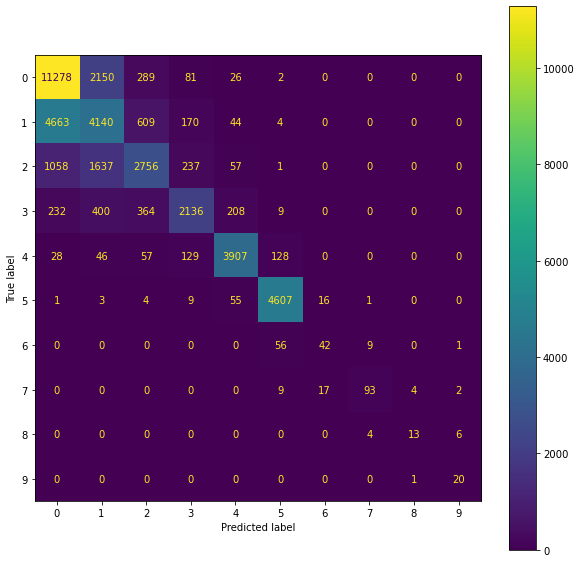

In [146]:
rounded_preds4 = np.argmax(preds4, axis = -1)

y_test4 = np.argmax(y_test, axis = -1)

cm4 = confusion_matrix(y_test4, rounded_preds4)

disp4 = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);
